In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import glob
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.signal import savgol_filter
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import KFold
import torch.nn.functional as F
import torch.nn.init as init
import torch.nn.utils as torch_utils
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from skopt import gp_minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import KernelPCA
import xgboost as xgb
import pandas as pd 
import random


In [2]:
file = pd.ExcelFile('Indoor MPP_1.0 sun_Air_ICN2_Feb. 2023_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl') 
sn = file.sheet_names  
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl')  
temperature = data_frame.loc[(data_frame["Parameter"]     =="Annealing temperature")].to_numpy()  
temperature = temperature[2,2:]  
devices = data_frame.columns.to_numpy()  
devices = np.reshape(devices, (devices.shape[0],1)) 
devices = devices[2:]
time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl')  
time_series_df = time_series_df.drop(index =[0]) 
time = time_series_df.iloc[:,0]  
time_series_1_air_sun = []
for i in range (temperature.shape[0]):
    time_series_1_air_sun.append(time_series_df.iloc[:,3+i*3])  
time_series_1_air_sun = np.array(time_series_1_air_sun)  


file = pd.ExcelFile('Indoor MPP_ICN2_Nov. 2022_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl') 
sn = file.sheet_names  
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl')  
temperature = data_frame.loc[(data_frame["Parameter"]     =="Annealing temperature")].to_numpy()  
temperature = temperature[2,2:]  
devices = data_frame.columns.to_numpy() 
devices = np.reshape(devices, (devices.shape[0],1)) 
devices = devices[2:]  
time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl')  
time_series_df = time_series_df.drop(index =[0])  
time = time_series_df.iloc[:,0]  
 
time_series_1_sun = []
for i in range (temperature.shape[0]):
    time_series_1_sun.append(time_series_df.iloc[:,3+i*3]) 
time_series_1_sun = np.array(time_series_1_sun) 


file = pd.ExcelFile('Indoor MPP_1.4 sun_ICN2_Feb. 2023_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl')
sn = file.sheet_names
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl')
devices = data_frame.columns.to_numpy()
devices = np.reshape(devices, (devices.shape[0],1))
devices = devices[2:]
time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl')
time_series_df = time_series_df.drop(index =[0])
time = time_series_df.iloc[:,0]
time_series_1_4_sun = []
for i in range (temperature.shape[0]):
    time_series_1_4_sun.append(time_series_df.iloc[:,3+i*3])
time_series_1_4_sun = np.array(time_series_1_4_sun)


outdoor_conditions = pd.read_csv('outdoor_conditions_unnormalized.txt', sep='\t')
irradiance = outdoor_conditions['irradiance']  
rh = outdoor_conditions['rh']  
outdoor_temperature = outdoor_conditions['outdoor_temperature']  
outdoor_condition_time = outdoor_conditions['time']  
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())
outdoor_temperature = outdoor_temperature.fillna(outdoor_temperature.mean())
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())


outdoor_panels = pd.read_csv('outdoor_data_imputed.txt', sep ='\t')
outdoor_panels_power = [] 
for i in range(temperature.shape[0]):
    outdoor_panels_power.append(outdoor_panels[str(i)])
outdoor_panels_power = np.array(outdoor_panels_power)  

time_series_1_air_sun_shape = time_series_1_air_sun.shape
time_series_1_sun_shape = time_series_1_sun.shape
time_series_1_4_sun_shape = time_series_1_4_sun.shape
time_series_1_air_sun = np.pad(time_series_1_air_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_air_sun.shape[1])),mode='edge') 
time_series_1_sun = np.pad(time_series_1_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_sun.shape[1])),mode='edge')    
time_series_1_4_sun = np.pad(time_series_1_4_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_4_sun.shape[1])),mode='edge' ) 
time_series_1_air_sun = np.reshape(time_series_1_air_sun, ((time_series_1_air_sun.shape[0],time_series_1_air_sun.shape[1],1)))   
time_series_1_sun = np.reshape(time_series_1_sun, ((time_series_1_sun.shape[0],time_series_1_sun.shape[1],1)))
time_series_1_4_sun = np.reshape(time_series_1_4_sun, ((time_series_1_4_sun.shape[0],time_series_1_4_sun.shape[1],1)))
outdoor_panels_power = np.reshape(outdoor_panels_power, ((outdoor_panels_power.shape[0],outdoor_panels_power.shape[1],1)))

In [3]:
time_series_1_air_sun_average = np.zeros((12, 4794, 1))
j = 0
for i in range(time_series_1_air_sun.shape[0]):
    if (i+1) % 2 == 0:
        time_series_1_air_sun_average[j] = np.mean(time_series_1_air_sun[i-1:i+1], axis=0)
        j += 1

time_series_1_sun_average = np.zeros((12, 4794, 1))
j = 0
for i in range(time_series_1_sun.shape[0]):
    if (i+1) % 2 == 0:
        time_series_1_sun_average[j] = np.mean(time_series_1_sun[i-1:i+1], axis=0)
        j += 1
 
time_series_1_4_sun_average = np.zeros((12, 4794, 1))
k = 0
for i in range(time_series_1_4_sun.shape[0]):
    if (i+1) % 2 == 0:
        time_series_1_4_sun_average[k] = np.mean(time_series_1_4_sun[i-1:i+1], axis=0)
        k += 1

outdoor_panels_power_average = np.zeros((12, 4794, 1))
b = 0
for i in range(outdoor_panels_power.shape[0]):
    if (i+1) % 2 == 0:
        outdoor_panels_power_average[b] = np.mean(outdoor_panels_power[i-1:i+1], axis=0)
        outdoor_panels_power_average[b][outdoor_panels_power_average[b] < 0] = 0 
        b += 1

outdoor_conditions_stacked = np.stack([outdoor_conditions ] * 12, axis=0)

In [4]:
all_new_features = np.concatenate((time_series_1_sun_average ,time_series_1_4_sun_average, outdoor_conditions_stacked[:, :, [2, 4]]), axis=2)

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA is available. Using GPU for computations.')
else:
    device = torch.device('cpu')
    print('CUDA is not available. Using CPU for computations.')

CUDA is not available. Using CPU for computations.


In [6]:
num_samples = all_new_features.shape[0]
all_new_features_reshaped = all_new_features.reshape(num_samples, -1)
outdoor_panels_power_average_reshaped = outdoor_panels_power_average.reshape(num_samples, -1)

num_folds = 12
average_mse_scores1 = []
average_mse_scores2 = []
fold = 0
y_pred1=np.zeros(( 1, 4794))
y_pred2=np.zeros(( 1, 4794))
predictions1 = np.zeros((12, 1, 4794))
test1= np.zeros((12, 1, 4794))
predictions2 = np.zeros((12, 1, 4794))
test2 = np.zeros((12, 1, 4794))

 
for temp in range(6):
    test_index=[2*temp,2*temp+1]
    train_index = [i for i in range(num_samples) if i not in test_index]
    X_train, X_test = all_new_features_reshaped [train_index], all_new_features_reshaped [test_index]
    y_train, y_test = outdoor_panels_power_average_reshaped[train_index], outdoor_panels_power_average_reshaped[test_index]
    scaler = StandardScaler()
    X_train= scaler.fit_transform(X_train)
    X_test= scaler.transform(X_test)
    print(X_test.shape)
    param_space = {
        'kernel': Categorical(['linear', 'rbf', 'poly']),
        'alpha': Real(0.001, 20.0, prior='log-uniform'),   
        'gamma': Real(0.0001, 20.0, prior='log-uniform'),   
        'degree': Integer(1, 5),   
        'coef0': Real(-2.0, 2.0),  
    }

    def objective_function(params):
        kernel = params[0]
        alpha = params[1]
        gamma = params[2]
        degree = params[3]
        coef0 = params[4]
        krr_model = KernelRidge(kernel=kernel, alpha=alpha, gamma=gamma, degree=degree, coef0=coef0)
        krr_model.fit(X_train, y_train)
        y_pred = krr_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        return mse
    result = gp_minimize(
        objective_function,
        dimensions=list(param_space.values()),
        n_calls=100,  
        random_state=42,

        verbose=0
    )


    best_params = dict(zip(param_space.keys(), result.x))
    print("Best Hyperparameters for Fold {}: {}".format(fold + 1, best_params))
    best_krr_model = KernelRidge(**best_params)
    best_krr_model.fit(X_train, y_train)

    y_pred1 = best_krr_model.predict(X_test[0].reshape(1, -1))
    y_pred2 = best_krr_model.predict(X_test[1].reshape(1, -1))
    predictions1[fold] = y_pred1
    predictions2[fold] = y_pred2
    test1[fold] = y_test[0]
    test2[fold] = y_test[1]
    error1 = mean_squared_error(y_test[0].reshape(1, -1), y_pred1)
    error2= mean_squared_error(y_test[1].reshape(1, -1), y_pred2)
    print("Fold {} - Mean Squared Error: {}".format(fold + 1, error1))
    print("Fold {} - Mean Squared Error: {}".format(fold + 1, error2))

    average_mse_scores1.append(error1)
    average_mse_scores2.append(error2)
    fold = fold + 1
    if fold == 6:
        break

average_mse1 = np.mean(average_mse_scores1)
average_mse2 = np.mean(average_mse_scores2)
print(f"Average Mean Squared Error: {average_mse1}")
print(f"Average Mean Squared Error: {average_mse2}")


(2, 19176)


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Best Hyperparameters for Fold 1: {'kernel': 'poly', 'alpha': 7.28510954561343, 'gamma': 0.0001, 'degree': 1, 'coef0': 2.0}
Fold 1 - Mean Squared Error: 0.5907959773809054
Fold 1 - Mean Squared Error: 0.0923426461630268
(2, 19176)


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\l

Best Hyperparameters for Fold 2: {'kernel': 'poly', 'alpha': 0.0309860462430293, 'gamma': 20.0, 'degree': 1, 'coef0': -0.06534550190839372}
Fold 2 - Mean Squared Error: 1.0915126425728934
Fold 2 - Mean Squared Error: 3.3450630513750466
(2, 19176)


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\l

Best Hyperparameters for Fold 3: {'kernel': 'poly', 'alpha': 0.3245065526110563, 'gamma': 0.0001, 'degree': 1, 'coef0': -0.19890724744427057}
Fold 3 - Mean Squared Error: 1.0790608310855192
Fold 3 - Mean Squared Error: 0.4766576142434413
(2, 19176)


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\l

Best Hyperparameters for Fold 4: {'kernel': 'poly', 'alpha': 1.5917541799612396, 'gamma': 0.0001, 'degree': 1, 'coef0': 0.1444223744772093}
Fold 4 - Mean Squared Error: 0.49567243748204154
Fold 4 - Mean Squared Error: 0.47814112297209516
(2, 19176)


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\l

Best Hyperparameters for Fold 5: {'kernel': 'poly', 'alpha': 0.4273056056637292, 'gamma': 0.00010900808140765598, 'degree': 1, 'coef0': 0.09909864103355703}
Fold 5 - Mean Squared Error: 0.10531016382236454
Fold 5 - Mean Squared Error: 0.6518186531124645
(2, 19176)


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\l

Best Hyperparameters for Fold 6: {'kernel': 'poly', 'alpha': 0.0028783255577416508, 'gamma': 14.123793468095819, 'degree': 1, 'coef0': -2.0}
Fold 6 - Mean Squared Error: 1.6215886972129105
Fold 6 - Mean Squared Error: 1.3743227508891207
Average Mean Squared Error: 0.8306567915927724
Average Mean Squared Error: 1.0697243064591992


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


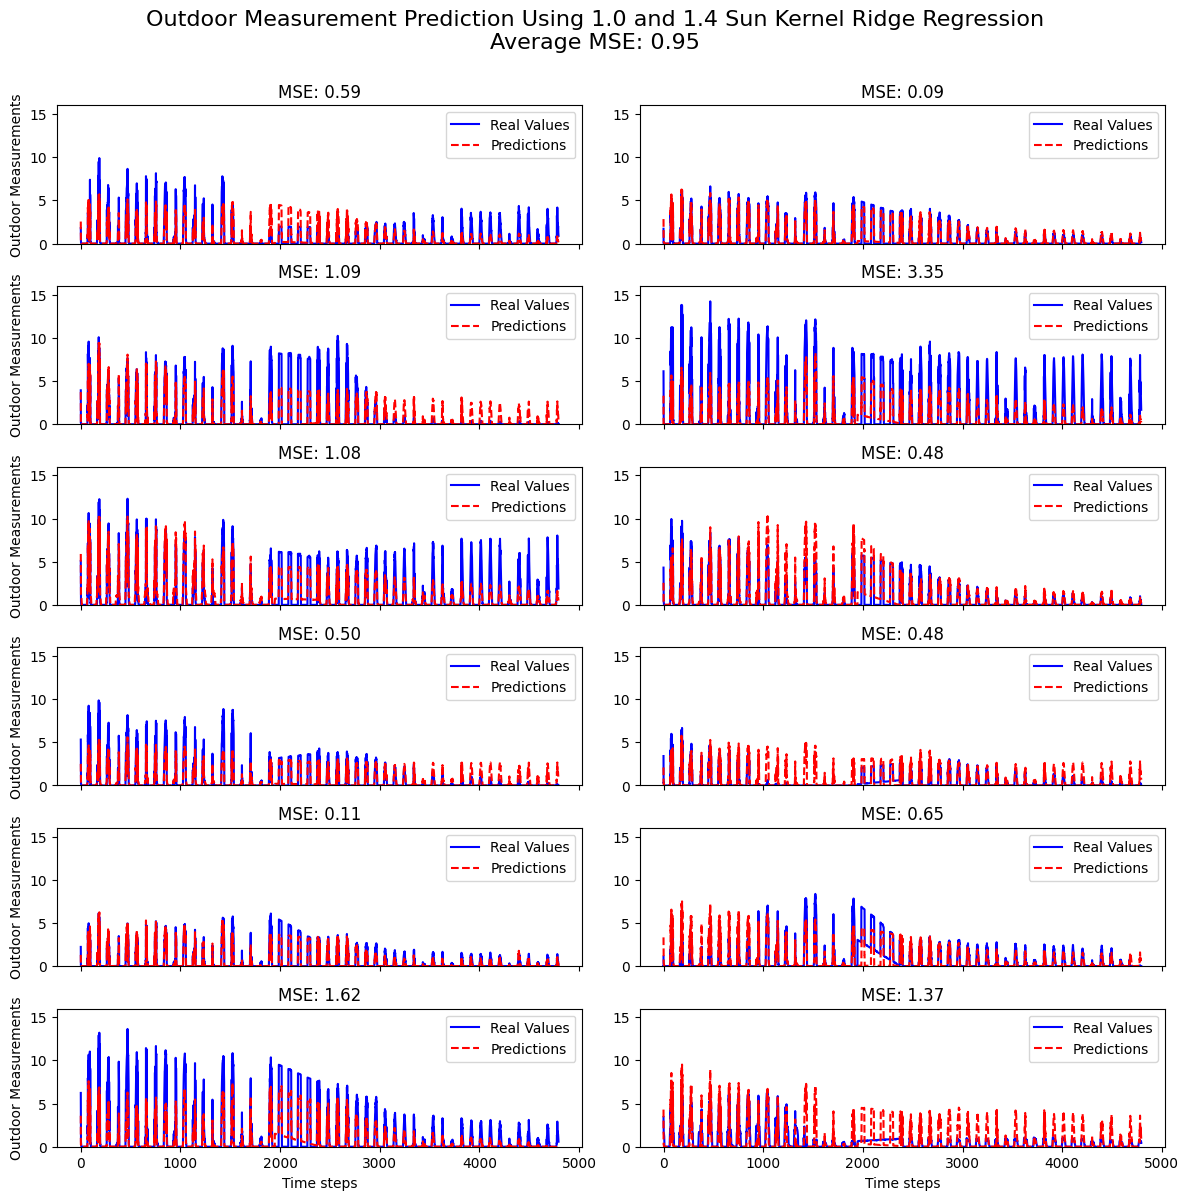

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 2, figsize=(12, 12), sharex=True)


for fold in range(6):
  
    y_pred_fold1 = predictions1[fold].squeeze()  
    y_pred_fold2 = predictions2[fold].squeeze()
    y_test_fold1 = test1[fold].squeeze()
    y_test_fold2 = test2[fold].squeeze()

    axes[fold, 0].plot(y_test_fold1, label='Real Values', color='blue')
    axes[fold, 0].plot(y_pred_fold1, label='Predictions', color='red',linestyle='dashed')
    axes[fold, 0].set_ylabel('Outdoor Measurements')
     
    axes[fold, 0].set_title(f'MSE: {average_mse_scores1[fold]:.2f}')
    axes[fold, 0].legend()
    axes[fold, 0].set_ylim(0, 16)
   
    axes[fold, 1].plot(y_test_fold2, label='Real Values', color='blue')
    axes[fold, 1].plot(y_pred_fold2, label='Predictions', color='red',linestyle='dashed')
     
    axes[fold, 1].set_title(f'MSE: {average_mse_scores2[fold]:.2f}') 
    axes[fold, 1].legend()
    axes[fold, 1].set_ylim(0, 16)

plt.tight_layout()
average_mse_all = (average_mse1+average_mse2)/2
axes[-1, 0].set_xlabel('Time steps')
axes[-1, 1].set_xlabel('Time steps')
fig.suptitle(f'Outdoor Measurement Prediction Using 1.0 and 1.4 Sun Kernel Ridge Regression\nAverage MSE: {average_mse_all:.2f}', fontsize=16)
fig.subplots_adjust(top=0.9)
plt.savefig('1.0 sun using krr.png')
plt.show()